In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(scales)
    library(GenomicFiles)
    library(limma)
    library(Biostrings)
});
set.seed(1026);
options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml");
theme_set(theme_classic(base_family = "Lucida Sans"));

In [2]:
# not all sequences are human, so they won't be in the bed file.
Size = fasta.seqlengths("./data/K562_AllTREs_110819.fa");

# load element coordinates
eSTARR = import.bed("./data/eSTARR_Clones_110819.bed")
names(eSTARR) = eSTARR$name;
eSTARR$name = NULL;
length(eSTARR);

invalidIDs = read_tsv( "./data/InvalidClones_110819.tsv", col_names = T );
invalidIDs = invalidIDs$ID[!invalidIDs$isValid];
eSTARR = eSTARR[!names(eSTARR) %in% invalidIDs];
length(eSTARR);

[1] 1105

Parsed with column specification:
cols(
  ID = col_character(),
  isValid = col_logical()
)



[1] 959

In [3]:
# controls defined by K562 luciferase assays.
NegCtrls = c( 'HS002', 'HS006', names(Size)[ substr(names(Size), 1, 3) == "ORF"] );
PosCtrls = c( 'HS001', 'HS005', 'CMV584', 'RSV', paste0("MYC_E", 1:7) );
Ctrls = c( NegCtrls, PosCtrls );

In [4]:
# load sequencing counts
BCTable = read.csv("./data/K562_eSTARR_UMIcounts.csv", header=T, sep=",", stringsAsFactors = F);
Size = Size[ names(Size) %in% BCTable$ID ];
BCTable = BCTable[ BCTable$ID %in% names(Size), ];
head(BCTable)

ID         Dir DNA1 DNA2 DNA3 RNA1  RNA2 RNA3 
1 CMV584     CCW 1624 1698 2478  1350 1008  1510
2 CMV584     CW  1886 1879 2880 11621 8576 15555
3 EGFP       CCW 2282 2431 3238  1664  901  1414
4 EGFP       CW  4506 4734 6410  5704 3348  4903
5 EKNGAE0004 CCW 1012 1141 1633   569  243   405
6 EKNGAE0004 CW   896 1018 1406   309  173   238

In [5]:
# normalize with counts per million,
# handling each direction seperately,
# using only elements tested in both batches.
isCW = BCTable$Dir == "CW";
hasRev = BCTable$ID %in% BCTable$ID[!isCW];
BCTable[ isCW,3:8] = t( 1E6 / colSums(BCTable[ isCW & hasRev,3:8]) * t(BCTable[ isCW,3:8]) );
BCTable[!isCW,3:8] = t( 1E6 / colSums(BCTable[!isCW & hasRev,3:8]) * t(BCTable[!isCW,3:8]) );
rownames(BCTable) = paste0(BCTable$ID, "-", BCTable$Dir);
head(BCTable)

ID         Dir DNA1      DNA2      DNA3      RNA1      RNA2     
CMV584-CCW     CMV584     CCW  998.4973  995.5383  858.8749 1928.5742 2430.2450
CMV584-CW      CMV584     CW   962.4919  917.0752  828.2843 5503.4202 7079.9032
EGFP-CCW       EGFP       CCW 1403.0609 1425.2965 1122.2909 2377.1463 2172.2725
EGFP-CW        EGFP       CW  2299.5697 2310.5024 1843.5078 2701.2743 2763.9361
EKNGAE0004-CCW EKNGAE0004 CCW  622.2163  668.9689  565.9978  812.8583  585.8626
EKNGAE0004-CW  EKNGAE0004 CW   457.2602  496.8508  404.3638  146.3348  142.8199
               RNA3     
CMV584-CCW     2672.4623
CMV584-CW      9647.0441
EGFP-CCW       2502.5574
EGFP-CW        3040.7880
EKNGAE0004-CCW  716.7862
EKNGAE0004-CW   147.6050

In [6]:
nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
# ignore any elements with <50 DNA CPM in any experiment
filter = rowMins(as.matrix(nDNA)) < 50;
filter = paste0( BCTable[filter,"ID"], "-", BCTable[filter,"Dir"] );
BCTable= BCTable[!rownames(BCTable) %in% filter,];
Size=Size[!names(Size) %in% as.character(filter)];
isCW = BCTable$Dir == "CW";

#write.csv(unique(npass), file="./out/PassFilter.csv");

In [7]:
# get normalized DNA and RNA matrices
nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
nRNA = BCTable[, grepl('RNA', colnames(BCTable), fixed=T) ];
# set identical column names
colnames(nDNA) = gsub('DNA', '', colnames(nDNA), fixed=T);
colnames(nRNA) = colnames(nDNA);

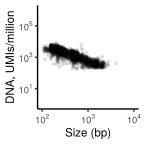

In [8]:
# plot normalized DNA and RNA counts vs element size
print(
    tibble(d=rowSums(nDNA), size = Size[BCTable$ID]) %>%
    ggplot(aes(x=size, y=d+0.1)) +
    scale_x_continuous( trans="log10", limits=10^c(2, 4), labels=trans_format("log10", math_format(10^.x)) ) +
    scale_y_continuous( trans="log10", limits=10^c(0, 6), labels=trans_format("log10", math_format(10^.x)) ) +
    xlab("Size (bp)") + ylab("DNA, UMIs/million") +
    geom_point(alpha=0.1, pch=19, size=0.5, show.legend=F)
);
#ggsave("./out/eSTARR_DNAvSize.pdf", width=2, height=2, device=cairo_pdf);

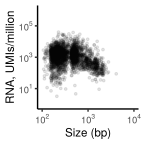

In [9]:
print(
    tibble(r=rowSums(nRNA), size = Size[BCTable$ID]) %>%
    ggplot(aes(x=size, y=r+0.1)) +
    scale_x_continuous( trans="log10", limits=10^c(2, 4), labels=trans_format("log10", math_format(10^.x)) ) +
    scale_y_continuous( trans="log10", limits=10^c(0, 6), labels=trans_format("log10", math_format(10^.x)) ) +
    xlab("Size (bp)") + ylab("RNA, UMIs/million") +
    geom_point(alpha=0.1, pch=19, size=0.5, show.legend=F)
);
#ggsave("./out/eSTARR_RNAvSize.pdf", width=2, height=2, device=cairo_pdf);

Warning message:
“Removed 43 rows containing missing values (geom_point).”
Warning message:
“Removed 42 rows containing missing values (geom_point).”


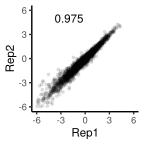

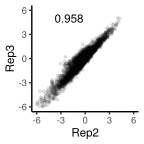

In [10]:
# plot raw fold-change across each replicate
repFC = log2(nRNA+1) - log2(nDNA);
print(
    tibble(one=repFC[,1], two=repFC[,2]) %>%
    ggplot(aes(x=one, y=two)) + xlim(-6, 6) + ylim(-6, 6) +
    xlab("Rep1") + ylab("Rep2") +
    geom_point(alpha=0.1, pch=19, size=0.5, show.legend=F) +
    geom_text(aes( -2, 5, label = round(cor.test(repFC[,1], repFC[,2])$estimate, 3)), data=data.frame(), color='black' )
);
print(
    tibble(one=repFC[,2], two=repFC[,3]) %>%
    ggplot(aes(x=one, y=two)) + xlim(-6, 6) + ylim(-6, 6) +
    xlab("Rep2") + ylab("Rep3") +
    geom_point(alpha=0.1, pch=19, size=0.5, show.legend=F) +
    geom_text(aes( -2, 5, label = round(cor.test(repFC[,2], repFC[,3])$estimate, 3)), data=data.frame(), color='black' )
);
#ggsave("./out/eSTARR_Reps.pdf", width=2, height=2, device=cairo_pdf);

In [11]:
Preformatted = cbind(nRNA, nDNA);
coldata = data.frame(
    RvD=rep(c(1, 0), each=3),
    Rep=1:3
);
options(contrasts=c("contr.sum","contr.poly"))
mdes = model.matrix(~RvD, data=coldata);

# estimate logFC using voom, blocking on rep number
vdata = voomWithQualityWeights(Preformatted, design=mdes, plot=F);
vcorrf = duplicateCorrelation(vdata, mdes, block = coldata$Rep)$consensus.correlation;
fit = eBayes(lmFit(vdata, mdes, block = coldata$Rep, correlation = vcorrf));

hits = topTable(fit, coef='RvD', number=Inf, sort.by = "none");
hits$ID = gsub("-", "", substr( rownames(hits), 1, nchar(rownames(hits))-3 ));
hits$Dir = gsub("-", "", substr( rownames(hits), nchar(rownames(hits))-2, nchar(rownames(hits)) ), fixed=T);
head(hits);

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achi

logFC      AveExpr   t         P.Value      adj.P.Val   
CMV584-CCW      1.2307494  9.545967 14.549749 7.538886e-13 3.665416e-12
CMV584-CW       2.9459101 10.326481 26.766793 2.038023e-18 6.292659e-17
EGFP-CCW        0.7329055  9.785764  9.686587 1.927127e-09 5.001511e-09
EGFP-CW         0.2983306 10.275414  4.161260 3.991104e-04 6.015781e-04
EKNGAE0004-CCW  0.1291865  8.370700  1.268024 2.179007e-01 2.458051e-01
EKNGAE0004-CW  -1.6815530  7.014775 -9.248003 4.437098e-09 1.092854e-08
               B         ID         Dir
CMV584-CCW     18.948125 CMV584     CCW
CMV584-CW      32.071579 CMV584     CW 
EGFP-CCW       10.812266 EGFP       CCW
EGFP-CW        -1.744413 EGFP       CW 
EKNGAE0004-CCW -7.238212 EKNGAE0004 CCW
EKNGAE0004-CW  10.799384 EKNGAE0004 CW

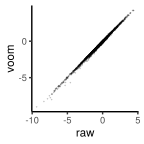

In [12]:
# plot voom logFC vs raw - close agreement at this seq depth...
print(
    tibble(raw=log2(rowSums(nRNA))-log2(rowSums(nDNA)), voom=hits$logFC) %>%
    ggplot(aes(x=raw, y=voom)) + geom_point(alpha=0.25, pch=18, size=0.5)
);

In [13]:
out = hits;
rownames(out) = paste0(hits$ID, "_", hits$Dir);

# only use controls with both CW + CCW data
negn = hits[hits$ID %in% NegCtrls, "ID"];
negn = negn[duplicated(negn)];

# get info from both directions
negCW = out[out$ID %in% negn & out$Dir == "CW",];
negCCW = out[out$ID %in% negn & out$Dir == "CCW",];
negv = c(negCW$logFC, negCCW$logFC);

# get stats in each direction. never compute means in log space!
CWneg = log2( mean( 2^negCW$logFC, na.rm=T ) );
CWpos = log2( mean( 2^unlist( out[out$ID %in% PosCtrls & out$Dir == "CW", "logFC"] ), na.rm=T ) );
CCWneg = log2( mean( 2^negCCW$logFC, na.rm=T ) );
CCWpos = log2( mean( 2^unlist( out[out$ID %in% PosCtrls & out$Dir == "CCW", "logFC"] ), na.rm=T ) );

#%>% filter(substr(ID, 1, 3) == "MYC")
# print average of Neg. and Pos. controls in each direction
round(CWneg, 3);
round(CCWneg, 3);
round(CWpos, 3);
round(CCWpos, 3);

[1] -0.611

[1] -0.156

[1] 2.489

[1] 2.816

Warning message:
“Removed 5 rows containing non-finite values (stat_density).”


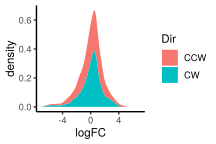

In [14]:
out$Size=Size[out$ID];
out$p = out$adj.P.Val;
# normalize logFC relative to neg controls
out$logFC= out$logFC - mean(negv);
out = out[,-(2:6)];
#write.csv(out, file="./out/logFCraw.csv", row.names=F);
options(repr.plot.width=3, repr.plot.height=2);
print( ggplot(data=out, aes(logFC, fill=Dir)) + stat_density() + xlim(-7, 7) );

Warning message:
“Ignoring unknown aesthetics: outfit, outfin”
Warning message:
“Removed 24 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 123 rows containing missing values (geom_point).”
Warning message:
“Removed 24 rows containing missing values (geom_point).”


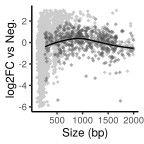

In [15]:
# Plot size bias of eSTARR logFC using neg controls (dark).
# Candidate elements (light) are not used to estimate size
# bias because they are expected to have biological signal.
options(repr.plot.width=2, repr.plot.height=2);
print(
    out %>%
    filter(ID %in% negn) %>%
    ggplot(aes(Size, logFC)) +
    scale_x_continuous( limits=c(100, 2000) ) +
    xlab("Size (bp)") + ylab("log2FC vs Neg.") +
    geom_point(pch=18, data=out[!out$ID %in% negn,], aes(Size, logFC), col="#cccccc") +
    geom_point(alpha=0.5, pch=18, col="#555555") + ylim(-6,3) +
    geom_smooth(method='loess', color='black', alpha=0.5, lwd=0.5, aes( outfit=ggy<<-..y.., outfin=ggx<<-..x.. ))
);
#ggsave("./out/eSTARR_SizeBias.pdf", width=3, height=2, device=cairo_pdf);

In [16]:
# Combine information from both directions (where possible)
# call active enhancers with 10% FDR in each direction (=> 1% FDR in both directions?)
Meffect = left_join( out %>% filter(Dir == "CW"), out %>% filter(Dir == "CCW"), by="ID", suffix=c(".CW", ".CCW") ) %>%
    mutate(
        logFC = log2(2^logFC.CW + 2^logFC.CCW) - 1,
        call = ifelse(p.CW <= .1 & p.CCW <= .1 & logFC.CW > 1 & logFC.CCW > 1, "Enhancer", "Inactive"),
        Dir.CW=NULL, Dir.CCW=NULL, Size=Size.CW, Size.CW=NULL, Size.CCW=NULL
    );
Meffect = Meffect[order(-Meffect$logFC),];
head(Meffect);

write.csv(Meffect, file="./K562_eSTARR_voom.csv", row.names=F);
#write_csv( Meffect, "./out/eSTARR_enhancers.csv" );

logFC.CW ID         p.CW         logFC.CCW p.CCW        logFC    call    
165  3.640463 EKSUUT0021 4.497538e-16 4.867859  3.801760e-23 4.380933 Enhancer
1104 3.400460 MYC_E1     1.577104e-16 4.854497  5.115470e-20 4.303397 Enhancer
723  3.184680 KSUUT0021  1.455531e-15 4.832314  1.761878e-22 4.231937 Enhancer
224  3.838453 EKUUAE0147 1.613650e-20 4.218781  2.593636e-20 4.041113 Enhancer
235  3.848726 EKUUAT0049 2.677381e-20 4.031421  2.208787e-20 3.942964 Enhancer
890  3.038115 KUUAE0106  8.677447e-17 4.492635  1.343766e-21 3.941405 Enhancer
     Size
165   662
1104 1578
723   382
224   532
235   621
890   521

In [17]:
# focus on KNG, KSS, KSU, KUU clones
TREs = Meffect[substr(Meffect$ID, 1, 1) == "K" | Meffect$ID %in% Ctrls, ];
Neutrals = Meffect[Meffect$ID %in% negn, ];

# remove deletion mutants (end with B or C)
TREs = TREs[!substr(TREs$ID, nchar(TREs$ID), nchar(TREs$ID)) %in% c("B", "C"),];
TREs$call[TREs$ID %in% NegCtrls] = "Negative";
TREs$call[TREs$ID %in% PosCtrls] = "Positive"
summary(factor(TREs$call));
TREs$call = factor(TREs$call, levels=c( "Inactive", "Negative", "Enhancer", "Positive") );

Enhancer Inactive Negative Positive 
      60      645      252        7

Warning message:
“Removed 11 rows containing missing values (geom_point).”


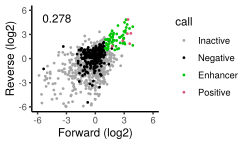

In [18]:
classc = c('#a6a6a6', 'black', '#00c405', '#d85475');
options(repr.plot.width=3.5, repr.plot.height=2);

# note computed correlation does not include controls
print(
    TREs %>% arrange(call) %>% filter(!is.na(logFC.CCW)) %>%
    ggplot(aes(logFC.CW, logFC.CCW, col=call)) +
    xlab("Forward (log2)") + ylab("Reverse (log2)") +
    geom_point(pch=16, size=0.5) +
    xlim(-6, 6) + ylim(-6, 6) +
    scale_color_manual(values=classc) +
    geom_text(aes( -4, 5, label = round(cor.test(TREs$logFC.CW, TREs$logFC.CCW)$estimate^2, 3)), data=data.frame(), color='black' )
)
#ggsave("./out/logFC_byDirection.pdf", width=2, height=2, device=cairo_pdf);

Warning message:
“Removed 4 rows containing missing values (geom_point).”


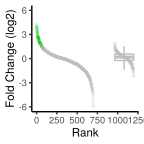

In [19]:
# plot averaged logFC from both directions
options(repr.plot.width=2, repr.plot.height=2);
print(
    TREs %>% filter(!ID %in% Ctrls) %>%
    ggplot(aes(1:length(logFC), logFC, color=call)) +
        scale_color_manual(values=c('gray', '#00c405')) +
        xlab("Rank") + ylab("Fold Change (log2)") +
        ylim(-6, 6) + guides(color='none') +
        geom_point(size=0.8, alpha=0.2, shape=16) +
        geom_boxplot(data=Neutrals, aes(x=nrow(TREs)+nrow(Neutrals)/2, y=logFC, col="Inactive"), outlier.shape=NA, width=nrow(Neutrals)) +
        geom_point(data=Neutrals, aes(x=nrow(TREs)+1:nrow(Neutrals), y=logFC, col=call), size=0.8, shape=16, alpha=0.2)
);
#ggsave("./out/TRE2vsNeg.pdf", width=2, height=2, device=cairo_pdf);

In [20]:
getLargestOverlap = function( query, subject ) {
    hits = findOverlaps(query, subject);
    hitQ = query[hits@from];
    hitS = subject[hits@to];
    overlaps = rowMins( cbind(end(hitS), end(hitQ)) ) - rowMaxs( cbind( start(hitS), start(hitQ) ) );
    
    # sort by overlap size (largest on top)
    hits = as.matrix(hits)[ order(overlaps, decreasing=T), ];
    # remove (now smaller) duplicates
    hits = hits[ !duplicated(hits[,1]), ];
    return(hits);
}

mcols(eSTARR) = TREs[match(names(eSTARR), TREs$ID),];
eSTARR = eSTARR[!is.na(eSTARR$logFC) & substr(names(eSTARR), 1, 1) == "K"];
eSTARR = eSTARR[!substr(names(eSTARR), nchar(names(eSTARR)), nchar(names(eSTARR))) %in% c("B", "C")];

In [21]:
#reannotate chromHMM classes with getLargestOverlap
# from http://egg2.wustl.edu/roadmap/data/byFileType/chromhmmSegmentations/ChmmModels/core_K27ac/jointModel/final/E123_18_core_K27ac_mnemonics.bed.gz
chromHMM = import("./data/E123_18_core_K27ac_mnemonics.bed.gz");
hits = getLargestOverlap(eSTARR, chromHMM);
eSTARR$cHMM[ hits[,1] ] = chromHMM$name[ hits[,2] ];
phmm = eSTARR$cHMM;
phmm[ !substr(phmm, 1, 2) %in% c("1_", "3_", "9_") ] = "99";
phmm = factor(substr(phmm, 1, 2));
levels(phmm) = c("TSS", "UpTSS", "Enh", "Other");

In [22]:
class = factor( substr(eSTARR$ID, 2, 3) != "NG" );
levels(class) = c( "Untranscribed", "Transcribed" );
etype = eSTARR$call;
eSTARR$phmm = phmm;

out = data.frame( class, phmm, etype ) %>%
    group_by(phmm, class, etype) %>% tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

phmm  class         etype    n   tot pct      lower    upper   
1 TSS   Untranscribed Inactive  83  84 98.80952 97.62616 99.99289
2 TSS   Transcribed   Inactive 131 137 95.62044 93.87208 97.36880
3 UpTSS Untranscribed Inactive  82  84 97.61905 95.95562 99.28247
4 UpTSS Transcribed   Inactive  74 100 74.00000 69.61366 78.38634
5 Enh   Untranscribed Inactive  84  85 98.82353 97.65400 99.99306
6 Enh   Transcribed   Inactive  48  68 70.58824 65.06273 76.11374

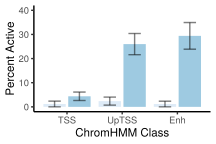

In [23]:
options(repr.plot.width=3, repr.plot.height=2);
print(
    ggplot(out, aes(x=phmm, y=100-pct, ymin=100-lower, ymax=100-upper, group=class, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("PRO-cap Class") +
    ylab("Percent Active") + xlab("ChromHMM Class")
);
#ggsave("./out/TRE2_ChromHMMhits.pdf", width=3, height=2, device=cairo_pdf);

In [24]:
# Load GENCODE protein-coding gene information
TX = read.table(gzfile("./data/gencode.v32lift37.annotation.gtf.gz"), header=F, sep="\t");
isGene = TX[,3] == "gene" & grepl("protein_coding", TX[,9], fixed=T);
TX = TX[ isGene, c(1,4,5) ];
colnames(TX) = c("chr", "start", "end");
TX = as(TX, "GRanges");

# Define gene promoters
TXtss = promoters(TX, upstream=500, downstream=500);
eSTARR$Location = "Distal";
TMap = findOverlaps( eSTARR, TXtss );
eSTARR$Location[ TMap@from ] = "Proximal";
loc = factor(eSTARR$Location, levels=c("Proximal", "Distal"));

In [25]:
out = data.frame( loc, phmm, etype ) %>%
    group_by(phmm, loc, etype) %>%
    tally() %>% mutate( tot=sum(n), pct = 100*n / tot );
out = out %>% filter(etype == "Inactive");
out

phmm  loc      etype    n   tot pct      
1 TSS   Proximal Inactive  53  54  98.14815
2 TSS   Distal   Inactive 161 167  96.40719
3 UpTSS Proximal Inactive   5   6  83.33333
4 UpTSS Distal   Inactive 151 178  84.83146
5 Enh   Proximal Inactive   2   2 100.00000
6 Enh   Distal   Inactive 130 151  86.09272

In [26]:
out = data.frame( loc, class, etype ) %>%
    group_by(loc, class, etype) %>%
    tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );

out = out %>% filter(etype == "Inactive");
out

loc      class         etype    n   tot pct       lower     upper    
1 Proximal Untranscribed Inactive   8   8 100.00000 100.00000 100.00000
2 Proximal Transcribed   Inactive  52  54  96.29630  93.72634  98.86625
3 Distal   Untranscribed Inactive 241 245  98.36735  97.55771  99.17698
4 Distal   Transcribed   Inactive 201 252  79.76190  77.23096  82.29285

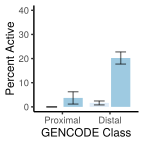

In [27]:
options(repr.plot.width=2, repr.plot.height=2);
print(
    ggplot(out, aes(x=loc, y=100-pct, ymin=100-lower, ymax=100-upper, group=class, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("PRO-cap Class") +
    ylab("Percent Active") + xlab("GENCODE Class")
);
#ggsave("./out/TRE2_GENCODEhits.pdf", width=2, height=2, device=cairo_pdf);

Warning message:
“Removed 10 rows containing non-finite values (stat_density).”


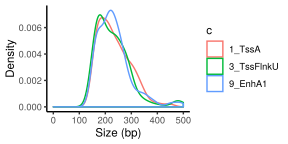

In [28]:
# plot element size vs ChromHMM class
options(repr.plot.width=4, repr.plot.height=2);
ggplot(data=data.frame(s=eSTARR$Size, c=eSTARR$cHMM), aes(s, color=c)) +
    stat_density(position="identity", alpha=0) +
    xlim(0, 500) + xlab("Size (bp)") + ylab("Density");
#ggsave("./out/TRE2_size_cHMM.pdf", width=4, height=2, device=cairo_pdf);

In [29]:
# compare activities with TSS+60 vs TSS+200 boundaries.
# TSS+60  elements were named  KXXCCNNNN.
# TSS+200 elements were named EKXXCCNNNN.
extdat = Meffect %>% filter(!is.na(logFC)) %>% # & !ID %in% invalidIDs) %>%
    mutate(p.CW=NULL, p.CCW=NULL, logFC.CW=NULL, logFC.CCW=NULL);
hasExt = extdat$ID %in% substr(extdat$ID, 2, 11) & substr(extdat$ID, 1, 1) == "K";
isExt  = substr(extdat$ID, 2, 11) %in% extdat$ID & substr(extdat$ID, 1, 1) == "E";
extdat[isExt,"ID"] = substr(extdat$ID[isExt], 2, 11);
extdat = left_join( extdat[hasExt,], extdat[isExt,], by="ID", suffix=c("", ".Ext") );

extdat = extdat %>% mutate(
    Class=factor(substr(extdat$ID, 2, 3) != "NG")
);
levels(extdat$Class) = c("Untranscribed", "Transcribed");
head(extdat)

ID        logFC    call     Size logFC.Ext call.Ext Size.Ext Class        
1 KSUUT0021 4.231937 Enhancer 382  4.380933  Enhancer 662      Transcribed  
2 KUUAE0071 3.847924 Enhancer 270  3.590349  Enhancer 550      Transcribed  
3 KUUAT0049 3.649848 Enhancer 341  3.942964  Enhancer 621      Transcribed  
4 KSUUT0008 3.573180 Enhancer 292  3.291551  Enhancer 572      Transcribed  
5 KNGUT0054 3.169618 Enhancer 175  1.831145  Enhancer 455      Untranscribed
6 KUUAE0147 2.907165 Enhancer 252  4.041113  Enhancer 532      Transcribed

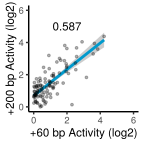

In [30]:
# plot TSS+200 activity against TSS+60
extdat = extdat %>% filter(logFC>0 & logFC.Ext>0);
eqtxt = round(cor.test(extdat$logFC, extdat$logFC.Ext)$estimate^2, 3);
options(repr.plot.width=2, repr.plot.height=2);

print(
    ggplot(extdat, aes(x=logFC, y=logFC.Ext)) +
    xlab("+60 bp Activity (log2)") + ylab("+200 bp Activity (log2)") +
    xlim(0, 6) + ylim(0, 6) + 
    geom_text(aes( 2, 5, label = eqtxt ), data=data.frame(), parse = T, col='black' ) +
    geom_smooth( method='lm', col='deepskyblue3', data=extdat, alpha=0.5 ) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5)
);
#ggsave("./out/TREs_60vs200.pdf", width=2, height=2, device=cairo_pdf);
#write_csv(extdat, "./out/TSS60vs200.csv");

In [31]:
# let's fit a full linear model to compare candidates
# vs negative controls, and validate previous heuristics.
rownames(repFC) = paste0(BCTable$ID, "_", BCTable$Dir);

# repeat neg ctrl values in each row
negmat = matrix(rep(negv, each=nrow(repFC)), ncol=length(negv), nrow=nrow(repFC));
Y = cbind( repFC, negmat );
dim(Y)

[1] 2995  469

In [32]:
# construct and fit a linear model
Nrep  = ncol(repFC);
Nele  = nrow(Y);
Nctrl = length(negv)/Nrep;
Erep  = rep( factor(1:Nrep), Nctrl+1 );
vsNeg = factor( c( rep(1, Nrep), rep(0, Nrep*Nctrl) )  );

options(contrasts=c("contr.sum","contr.poly"));

design <- model.matrix(~vsNeg);
fitF <- eBayes(lmFit( Y[ isCW,], design ));
fitR <- eBayes(lmFit( Y[!isCW,], design ));

In [33]:
resF = topTable(fitF, coef = "vsNeg1", sort.by="none", number=Inf);
resR = topTable(fitR, coef = "vsNeg1", sort.by="none", number=Inf);

resF$B=NULL;
resF$t=NULL;
resF$AveExpr=NULL;
resF$P.Value=NULL;
colnames(resF)[2] = "q";
colnames(resF) = paste0(colnames(resF), ".CW");
resF$ID = BCTable$ID[isCW];
#
resF$logFC.CW  = -2*resF$logFC.CW;
resF$logFC.CCW = -2*resR[resF$ID,"logFC"];
resF$q.CCW = resR[resF$ID, "adj.P.Val"];
resF$logFC = log(2^resF$logFC.CW + 2^resF$logFC.CCW, 2)-1;
resF$size = Size[resF$ID];

hitsF = resF$q.CW  < 0.2 & resF$logFC.CW  > 0;
hitsR = resF$q.CCW < 0.2 & resF$logFC.CCW > 0;
resF$call = "Inactive";
resF$call[hitsF & hitsR] = "Enhancer";
resF$call[resF$ID %in% NegCtrls] = "Negative";
resF$call[resF$ID %in% PosCtrls] = "Positive"
resF$call = factor(resF$call, levels=c( "Inactive", "Negative", "Enhancer", "Positive") );

resF = resF[!is.na(resF$ID),];
head(resF);

logFC.CW   q.CW         ID         logFC.CCW q.CCW     
CMV584_CW      3.6267406 1.593805e-09 CMV584     1.9168019 0.00240310
EGFP_CW        1.0293111 1.585370e-01 EGFP       1.4670057 0.02316529
EKNGAE0004_CW -0.9976733 1.740525e-01 EKNGAE0004 0.8049401 0.24410160
EKNGAE0006_CW  0.9274660 2.100475e-01 EKNGAE0006 0.8003669 0.24734369
EKNGAE0008_CW -0.8432950 2.624441e-01 EKNGAE0008 0.3287723 0.65887747
EKNGAE0021_CW -0.5251873 5.101691e-01 EKNGAE0021 0.7353519 0.29463548
              logFC      size call    
CMV584_CW      3.0115343 584  Positive
EGFP_CW        1.2646940 717  Enhancer
EKNGAE0004_CW  0.1685652 504  Inactive
EKNGAE0006_CW  0.8653156 483  Inactive
EKNGAE0008_CW -0.1413718 504  Inactive
EKNGAE0021_CW  0.2385866 459  Inactive

In [34]:
TREs = resF[substr(resF$ID, 1, 1) == "K" | resF$ID %in% Ctrls, ];
Neutrals = resF[resF$ID %in% negn, ];

# remove deletion mutants (end with B or C)
TREs = TREs[!substr(TREs$ID, nchar(TREs$ID), nchar(TREs$ID)) %in% c("B", "C"),];
summary(factor(TREs$call));

Inactive Negative Enhancer Positive 
     642      252       63        7

In [35]:
mcols(eSTARR) = resF[match(names(eSTARR), resF$ID),];
eSTARR = eSTARR[!is.na(eSTARR$logFC) & substr(names(eSTARR), 1, 1) == "K"];
eSTARR = eSTARR[!substr(names(eSTARR), nchar(names(eSTARR)), nchar(names(eSTARR))) %in% c("B", "C")];

class = factor( substr(eSTARR$ID, 2, 3) != "NG" );
levels(class) = c( "Untranscribed", "Transcribed" );
etype = eSTARR$call;
eSTARR$phmm = phmm;

out = data.frame( class, phmm, etype ) %>%
    group_by(phmm, class, etype) %>% tally() %>%
    mutate( tot=sum(n), pct = 100*n / tot,
            lower = pct - 100*sqrt( pct*(100-pct)/tot/1E4 ),
            upper = pct + 100*sqrt( pct*(100-pct)/tot/1E4 ) );
out = out %>% filter(etype == "Inactive");
out

phmm  class         etype    n   tot pct      lower    upper   
1 TSS   Untranscribed Inactive  83  84 98.80952 97.62616 99.99289
2 TSS   Transcribed   Inactive 130 137 94.89051 93.00929 96.77173
3 UpTSS Untranscribed Inactive  82  84 97.61905 95.95562 99.28247
4 UpTSS Transcribed   Inactive  73 100 73.00000 68.56041 77.43959
5 Enh   Untranscribed Inactive  84  85 98.82353 97.65400 99.99306
6 Enh   Transcribed   Inactive  47  68 69.11765 63.51497 74.72032

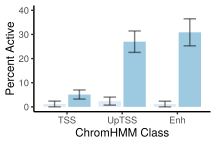

In [36]:
options(repr.plot.width=3, repr.plot.height=2);
print(
    ggplot(out, aes(x=phmm, y=100-pct, ymin=100-lower, ymax=100-upper, group=class, fill=class)) +
    coord_cartesian(ylim=c(0, 40)) +
    geom_col( pos=position_dodge2(), show.legend = F ) +
    geom_errorbar( pos=position_dodge2(width=0.5, padding=0.5), alpha=0.5, show.legend = F ) +
    scale_fill_brewer("GRO-cap Class") +
    ylab("Percent Active") + xlab("ChromHMM Class")
);